In [ ]:
from pathlib import Path
from collections import OrderedDict
from typing import List
from copy import deepcopy
import pickle

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
from scipy import interpolate

### Functions

In [23]:
# 1 for OOD, 0 for IND
# Now, for each TPR threshold, we compute the TP, FP, TN, FN values
# We also compute the precision, recall (TPR) and FPR 
# True Positive     (TP) is an IND detected as IND
# False Positive    (FP) is an OOD detected as IND
# True Negative     (TN) is an OOD detected as OOD
# False Negative    (FN) is an IND detected as OOD
# TPR = TP / (TP + FN)
# FPR = FP / (FP + TN)
# precision = TP / (TP + FP)
def compute_tpr_fpr_precision_for_auroc(activations: np.array, ground_truth: np.array, thresholds: np.array) -> (np.array, np.array, np.array):
    TPR = []
    FPR = []
    PRECISION = []

    # Compute the predictions for each TPR threshold
    preds_per_thr = []
    for thr in thresholds:
        preds_per_thr.append((activations >= thr).astype(int))
    
    # Compute the TP, FP, TN, FN values for the predictions, all stored in one array
    tp_fp_tn_fn = []
    tpr_fpr_precision = []
    for i, preds_one_thr in enumerate(preds_per_thr):
        tp = np.sum(preds_one_thr[ground_truth == 0] == 0)
        fp = np.sum(preds_one_thr[ground_truth == 1] == 0)
        tn = np.sum(preds_one_thr[ground_truth == 1] == 1)
        fn = np.sum(preds_one_thr[ground_truth == 0] == 1)
        tp_fp_tn_fn.append([tp, fp, tn, fn])
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        tpr_fpr_precision.append([tpr, fpr, precision])
        # TPR.append(tpr)
        # FPR.append(fpr)
        # PRECISION.append(precision)

    # TPR = np.array(TPR)
    # FPR = np.array(FPR)
    # PRECISION = np.array(PRECISION)
    
    #tpr_fpr_precision = np.sort(np.array(tpr_fpr_precision), axis=0)
    tpr_fpr_precision = np.sort(np.array(tpr_fpr_precision), axis=0)
    
    return tpr_fpr_precision


def plot_auroc(tpr_values, fpr_values):
    auroc_value = np.abs(np.trapz(tpr_values, fpr_values))
    tpr_percentages = np.arange(0, 1.01, 0.01)
    plt.figure(figsize=(15, 12))
    plt.plot(fpr_values, tpr_values, label='ROC curve', lw=3)
    plt.plot(tpr_percentages, tpr_percentages, 'k--', label='Random ROC curve')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('FPR', fontsize=20)
    plt.ylabel('TPR', fontsize=20)
    plt.title(f'ROC curve, AUC = {auroc_value:0.3f}', fontsize=25, pad=10)
    plt.fill_between(fpr_values, tpr_values, alpha=0.3)
    # plt.plot([], [], ' ', label=f'FPR at 95% TPR = {fpr_values[95] * 100:.2f}%')
    # plt.plot([], [], ' ', label=f'FPR at 80% TPR = {fpr_values[80] * 100:.2f}%')
    # plt.text(0.60,0.975,'FPR at 95% TPR = {}%'.format(round(array_TPR_FPR_x_threshold[95,1]*100,2)),fontsize=20,bbox=dict(boxstyle="round",facecolor='white', alpha=0.5))
    plt.legend(fontsize=20, loc='upper left')
    plt.show()


def compute_auroc_per_method(results_per_method: dict, per_step_results: bool = False, which_tpr_for_the_fpr=0) -> dict:

    # Compute AUROC and sort the results by the AUROC value
    auroc_values_per_method = OrderedDict()
    methods_names = []
    fpr_at_certain_tpr = []
    for method_name, results in results_per_method.items():
        if isinstance(results, list):
            TPR, FPR, PRECISION = results

        elif isinstance(results, np.ndarray):
            TPR, FPR, PRECISION = results[:, 0], results[:, 1], results[:, 2]
        
        else:
            raise ValueError("The results must be a tuple, list or array")

        if which_tpr_for_the_fpr > 0:
            # Compute the TPR at a certain FPR
            index_closest = np.argmin(np.abs(TPR - which_tpr_for_the_fpr))
            fpr_at_certain_tpr.append(FPR[index_closest])
            auroc_values_per_method[method_name] = [np.abs(np.trapz(TPR, FPR)), FPR[index_closest]]
        else:
            auroc_values_per_method[method_name] = np.abs(np.trapz(TPR, FPR))

    # # Convert the lists into numpy arrays
    # auroc_values = np.array(auroc_values)

    return auroc_values_per_method

def plot_auroc_per_method(results_per_method: dict, figsize, title, which_tpr_to_plot: float = 0.80, plot_random_curve: bool = False, save_path: Path = None):
    
    # Create the figure
    plt.figure(figsize=figsize)

    # Fontsize as a function of the figure size
    fontsize = int(figsize[0] * 2)

    # # Only considering the first column
    # first_column = results_per_method['forward_dynamics_l1'][:, 0]

    # # Find the index of the value closest to the target
    # index_closest = np.argmin(np.abs(first_column - which_fpr_to_plot))

    # Compute AUROC and sort the results by the AUROC value
    auroc_values = []
    methods_names = []
    fpr_at_certain_tpr = []
    for method_name, results in results_per_method.items():
        if isinstance(results, list):
            TPR, FPR, PRECISION = results

        elif isinstance(results, np.ndarray):
            TPR, FPR, PRECISION = results[:, 0], results[:, 1], results[:, 2]
        
        else:
            raise ValueError("The results must be a tuple, list or array")
        
        # Add the method name to the list
        methods_names.append(method_name)
        
        # Compute the AUROC value
        auroc_values.append(np.abs(np.trapz(TPR, FPR)))
        
        # Compute the TPR at a certain FPR
        index_closest = np.argmin(np.abs(TPR - which_tpr_to_plot))
        fpr_at_certain_tpr.append(FPR[index_closest])      

    # Convert the lists into numpy arrays
    auroc_values = np.array(auroc_values)
    
    # Sort the methods by the AUROC value
    sorted_indices = np.argsort(auroc_values)[::-1]
    auroc_values = auroc_values[sorted_indices]
    methods_names = np.array(methods_names)[sorted_indices]
    fpr_at_certain_tpr = np.array(fpr_at_certain_tpr)[sorted_indices]

    # Plot the AUROC values
    for method_name, auroc_value in zip(methods_names, auroc_values):
        TPR, FPR, PRECISION = results_per_method[method_name][:, 0], results_per_method[method_name][:, 1], results_per_method[method_name][:, 2]
        plt.plot(FPR, TPR, label=rf'AUC={auroc_value:0.3f} - {method_name} ', lw=3)

    # Random curve
    if plot_random_curve:
        random_classifier_points = np.arange(0, 1.01, 0.01)
        plt.plot(random_classifier_points, random_classifier_points, 'k--', label='Random')
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('FPR', fontsize=fontsize)
    plt.ylabel('TPR', fontsize=fontsize)
    plt.title(f'ROC curve- {title}', fontsize=fontsize, pad=10)
    plt.legend(fontsize=fontsize, loc='lower right')

    if which_tpr_to_plot > 0:
        # Plot the TPR at a certain FPR as text. We will plot the text in the same order as the methods are plotted
        # To do so, we will iterate over the sorted indices to accumulate the text as a big string containing the substring of 
        # each methods TPR value
        fpr_at_certain_tpr_text = ""
        # Put a title to the text
        fpr_at_certain_tpr_text += f"FPR at {which_tpr_to_plot * 100:.0f}% TPR\n"
        for method_name, fpr_at_certain_tpr_value in zip(methods_names, fpr_at_certain_tpr):
            fpr_at_certain_tpr_text += f" {fpr_at_certain_tpr_value * 100:.2f}% - {method_name}\n"
        plt.text(0.50,0.5,fpr_at_certain_tpr_text,fontsize=20,bbox=dict(boxstyle="round",facecolor='white', alpha=0.5))
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# plt.text(0.60,0.975,'FPR at 95% TPR = {}%'.format(round(array_TPR_FPR_x_threshold[95,1]*100,2)),fontsize=20,bbox=dict(boxstyle="round",facecolor='white', alpha=0.5))

def extract_tpr_fpr_precision_from_results_file(results: dict, per_step_results: bool) -> np.ndarray:
    # Extract the IND activations for the thresholds and all the activations for the tests
    if per_step_results:
        all_activations = results[:, 2]
        ground_truth_per_step = results[:, 0]
    else:
        all_activations = []
        ground_truth_per_step = []
        for k, v in results.items():
            all_activations.append(v[:, 1])
            ground_truth_per_step.append(v[:, 0])
        # Concatenate all the activations and ground truth
        all_activations = np.concatenate(all_activations)
        ground_truth_per_step = np.concatenate(ground_truth_per_step)
    # Sort the activations and ground truth
    sorted_indices = np.argsort(all_activations)
    all_activations = all_activations[sorted_indices]
    ground_truth_per_step = ground_truth_per_step[sorted_indices]
    # Create the in and out of distribution activations arrays
    in_distribution_activations = all_activations[ground_truth_per_step == 0]
    ood_activations = all_activations[ground_truth_per_step == 1]

    # Compute the thresholds to cover all the auroc curve (from 0 to 1 tpr and fpr)
    tpr_fpr_percentages = np.arange(0, 1.01, 0.01)
    thresholds = []
    for percent in tpr_fpr_percentages:
        thresholds.append(np.quantile(in_distribution_activations, percent, method="nearest"))
        thresholds.append(np.quantile(ood_activations, percent, method="nearest"))
    thresholds = np.unique(thresholds)

    # Compute the TPR, FPR and precision for each threshold
    tpr_fpr_precision = compute_tpr_fpr_precision_for_auroc(all_activations, ground_truth_per_step, thresholds)

    return tpr_fpr_precision


def extract_tpr_fpr_precision_per_distance_to_ood_from_results_file(results: dict, per_step_results: bool) -> List:
    all_activations = results[:, 2]
    ground_truth_distance_per_step = results[:, 1]
    # Sort the activations and ground truth
    sorted_indices = np.argsort(all_activations)
    all_activations = all_activations[sorted_indices]
    ground_truth_distance_per_step = ground_truth_distance_per_step[sorted_indices]

    # Now we evaluate for each distance to the OOD element separately
    idx_in_distribution = np.argwhere(ground_truth_distance_per_step == 0)[:,0]
    in_distribution_activations = all_activations[idx_in_distribution]
    tpr_fpr_precision_per_distance = []
    for distance in np.unique(ground_truth_distance_per_step)[1:]:  # We skip the 0 distance
        # Create the in and out of distribution activations arrays
        idx_oods = np.argwhere(ground_truth_distance_per_step == distance)[:,0]
        ood_activations = all_activations[idx_oods]
        # Compute the thresholds to cover all the auroc curve (from 0 to 1 tpr and fpr)
        tpr_fpr_percentages = np.arange(0, 1.01, 0.01)
        thresholds = []
        for percent in tpr_fpr_percentages:
            thresholds.append(np.quantile(in_distribution_activations, percent, method="nearest"))
            thresholds.append(np.quantile(ood_activations, percent, method="nearest"))
        thresholds = np.unique(thresholds)

        # Compute the TPR, FPR and precision for each threshold. The ground truth is the distance to the OOD element
        # so we must convert it to a binary ground truth (0 for IND, 1 for OOD)
        ground_truth_for_one_distance = (np.zeros_like(ground_truth_distance_per_step)+1)*-1
        ground_truth_for_one_distance[idx_oods] = 1
        ground_truth_for_one_distance[idx_in_distribution] = 0

        tpr_fpr_precision_per_distance.append([distance, compute_tpr_fpr_precision_for_auroc(all_activations, ground_truth_for_one_distance, thresholds)])
    return tpr_fpr_precision_per_distance

def compute_auroc_and_fpr_for_all_seeds(results_per_seed: List, which_tpr_for_the_fpr=0.95) -> dict:
    fpr_at_certain_tpr = []
    auroc_fpr_all_seeds = []
    for i, values in enumerate(results_per_seed):
        
        TPR, FPR, PRECISION = values[:, 0], values[:, 1], values[:, 2]

        # Compute the TPR at a certain FPR
        index_closest = np.argmin(np.abs(TPR - which_tpr_for_the_fpr))
        fpr_at_certain_tpr.append(FPR[index_closest])
        auroc_fpr_all_seeds.append([np.abs(np.trapz(TPR, FPR)), FPR[index_closest]])

    # Convert the lists into numpy arrays
    auroc_fpr_all_seeds = np.array(auroc_fpr_all_seeds)
    # Now compute the mean and std
    auroc_mean = np.mean(auroc_fpr_all_seeds[:, 0])
    auroc_std = np.std(auroc_fpr_all_seeds[:, 0])
    fpr_mean = np.mean(auroc_fpr_all_seeds[:, 1])
    fpr_std = np.std(auroc_fpr_all_seeds[:, 1])
    
    # Create an array with the mean and std of the auroc and fpr
    auroc_fpr_mean_std = np.array([[auroc_mean, auroc_std], [fpr_mean, fpr_std]])
    return auroc_fpr_mean_std

#def compute_auroc_and_fpr_vs_distance_for_all_seeds()
    
def avg_and_std_per_distance(auroc_per_seed_per_distance: List) -> List:
    auroc_per_distance = []

    #print(auroc_per_seed_per_distance)
    # print(len(auroc_per_seed_per_distance))
    # print(len(auroc_per_seed_per_distance[0]))
    # Accumulate the auroc of each seed for each distance
    auroc_per_distance_all_seeds = OrderedDict()
    for i in range(1, len(auroc_per_seed_per_distance[0])+1):
        auroc_per_distance_all_seeds[i] = []

    for i, values_one_seed in enumerate(auroc_per_seed_per_distance):
        for distance, auroc_val, fpr_at_certain_tpr in values_one_seed:
            auroc_per_distance_all_seeds[int(distance)].append(auroc_val)
    
    # Now compute the mean and std
    for d, auroc_one_dist_all_seeds in auroc_per_distance_all_seeds.items():
        #print(d, auroc_one_dist_all_seeds)
        auroc_per_distance.append([np.mean(auroc_one_dist_all_seeds), np.std(auroc_one_dist_all_seeds)])
    
    return auroc_per_distance

### Collect data from seeds (AUROC and per env)

In [24]:
# PER STEP and for all environments
# Define folder path
detection_results_folder = Path("ood_storage/detection_results")

ood_settings_to_benchmark = [
    'Lava010',
    'Ball100',
    'Sand050',
]

per_step_or_per_level_evaluation = 'per_steps'

seeds = [1,2,3,4,5]

model_name = 'P_MN5S8_1000_lvls_r_ep_im005_ent00005'

methods_to_benchmark = ['forward_dynamics_l1', 'forward_dynamics_l2', 'l1', 'l2',
                        'l1_per_action', 'l2_per_action', 'msp', 'energy',]

# Useless parameter, but it is required to load the file. Leave it as 9
ood_detection_distance = 9

# Only used in case we want to compute the TPR at a certain FPR
which_tpr_for_the_fpr = 0.95

results_per_ood_env_per_method = OrderedDict()
auroc_per_env_per_method_per_distance = OrderedDict()
for ood_env in ood_settings_to_benchmark:
    
    # Only consider the .pt files in the folder
    results_per_method = OrderedDict()
    # results_per_method_per_distance = OrderedDict()
    auroc_per_method_per_distance = OrderedDict()
    for method_name in methods_to_benchmark:
        
        auroc_per_seed_per_distance = []
        results_per_seed = []
        for s in seeds:
            
            file_name = f'ood_detection_results_per_steps_{method_name}_{model_name}_{s}_{ood_env}_ood_performance_evaluation_normal_vs_lava_09_{s:02d}.pt'

            file_path = detection_results_folder / file_name

            # if not file_path.exists():
            #     print(f"File {file_path} does not exist")
            #     continue
            # continue

            # Load the results
            results = torch.load(file_path)

            ## Results for all distances ##
            # Results for all distances. Compute the TPR, FPR and precision to plot auroc. Store the results
            results_per_seed.append(extract_tpr_fpr_precision_from_results_file(results=results, per_step_results=True))

            ## Results per distance to the OOD element ##
            # Each position in this list is a distance to the OOD element. Each distance has the TPR, FPR and precision for each threshold
            tpr_fpr_precision_per_distance_one_seed = extract_tpr_fpr_precision_per_distance_to_ood_from_results_file(results, per_step_results=True)

            # Compute the AUROC per distance for each seed. Each position in the list is a seed, and each seed has a list of distances (1 to 9)
            #total_auroc_per_method[method_name] = np.abs(np.trapz(results_per_method[method_name][:, 0], results_per_method[method_name][:, 1]))
            #auroc_and_fpr_values_per_method_per_distance[method_name] = []
            values_per_distance = []
            for dist in tpr_fpr_precision_per_distance_one_seed:
                TPR, FPR, PRECISION = dist[1][:, 0], dist[1][:, 1], dist[1][:, 2]
                auroc_value = np.abs(np.trapz(TPR, FPR))
                # Compute the TPR at a certain FPR
                index_closest = np.argmin(np.abs(TPR - which_tpr_for_the_fpr))
                fpr_at_certain_tpr = FPR[index_closest]
                values_per_distance.append([dist[0], auroc_value, fpr_at_certain_tpr])
            # Store the results for each seed
            auroc_per_seed_per_distance.append(values_per_distance)            

            ### Finished one seed ###
        
        ## All distances ##
        # Auroc for all distances, one method, for all seeds. Store the results of each method
        results_per_method[method_name] = compute_auroc_and_fpr_for_all_seeds(results_per_seed=results_per_seed, which_tpr_for_the_fpr=0.95)
        # The array has the shape (2, 2), where the first row is the mean and std of the auroc and the second row is the mean and std of the fpr
        #  [[auroc_mean, auroc_std],
        #   [fpr_mean,   fpr_std  ]]         

        ## Per distance ##
        # Auroc per distance, one method, for all seeds
        auroc_per_method_per_distance[method_name] = avg_and_std_per_distance(auroc_per_seed_per_distance)

        print(f"Finished method {method_name} for env {ood_env}")
    
    # Store the results of each environment
    # All distances
    results_per_ood_env_per_method[ood_env] = results_per_method

    # Per distance
    auroc_per_env_per_method_per_distance[ood_env] = auroc_per_method_per_distance

# Convert the lists into numpy arrays
for env in auroc_per_env_per_method_per_distance.keys():
    for method in auroc_per_env_per_method_per_distance[env].keys():
        #print(f"{env} - {method}: {np.array(auroc_per_env_per_method_per_distance[env][method]).shape}")
        auroc_per_env_per_method_per_distance[env][method] = np.array(auroc_per_env_per_method_per_distance[env][method])

Finished method forward_dynamics_l1 for env Lava010
Finished method forward_dynamics_l2 for env Lava010
Finished method l1 for env Lava010
Finished method l2 for env Lava010
Finished method l1_per_action for env Lava010
Finished method l2_per_action for env Lava010
Finished method msp for env Lava010
Finished method energy for env Lava010
Finished method forward_dynamics_l1 for env Ball100
Finished method forward_dynamics_l2 for env Ball100
Finished method l1 for env Ball100
Finished method l2 for env Ball100
Finished method l1_per_action for env Ball100
Finished method l2_per_action for env Ball100
Finished method msp for env Ball100
Finished method energy for env Ball100
Finished method forward_dynamics_l1 for env Sand050
Finished method forward_dynamics_l2 for env Sand050
Finished method l1 for env Sand050
Finished method l2 for env Sand050
Finished method l1_per_action for env Sand050
Finished method l2_per_action for env Sand050
Finished method msp for env Sand050
Finished method 

### Table of AUROC per method

In [ ]:
# Save the results auroc_per_env_per_method_per_distance as a pickle file
with open(f'ood_storage/auroc_per_env_per_method_per_distance.pkl', 'wb') as f:
    pickle.dump(auroc_per_env_per_method_per_distance, f)

In [4]:
# Transforming into a Pandas DataFrame
# Flattening the data and keeping only the first value of each list
flattened_data = {scenario: {method: values[0][0] for method, values in methods.items()} 
                  for scenario, methods in results_per_ood_env_per_method.items()}

df = pd.DataFrame(flattened_data)
# Add a new column with the average
#df['Average'] = df.mean(axis=1)

# Sort the index as this list
new_order = ['forward_dynamics_l1', 'forward_dynamics_l2', 'l1', 'l2', 'l1_per_action', 'l2_per_action', 'msp', 'energy']
df = df.reindex(new_order)
# Show them as percentages rounded to 2 decimals in string format
df = df.map(lambda x: f'{x * 100:.2f}')
# Change the index names and column names for the ones in the lists
new_names = ['FwD-L1', 'FwD-L2', 'L1', 'L2', 'L1-A', 'L2-A', 'MSP', 'Energy']
new_env_names = ['\texttt{Lava}', '\texttt{Ball}', '\texttt{Sand}']
#new_env_names = ['\texttt{Lava}', '\texttt{Ball}', '\texttt{Sand}', 'Average']
df.columns = new_env_names
df.index = new_names

# Save the dataframe as a latex table
df.to_latex(f'ood_storage/auroc_per_setting_per_method.tex')
df

,\texttt{Lava},\texttt{Ball},\texttt{Sand}
FwD-L1,88.39,70.10,77.48
FwD-L2,87.80,69.59,75.64
L1,84.30,59.70,84.46
L2,84.82,60.30,84.91
L1-A,81.13,56.41,80.32
L2-A,82.41,57.30,81.53
MSP,48.22,58.04,63.36
Energy,75.89,59.93,77.72


### AUROC vs Distance plots

#### Only one env

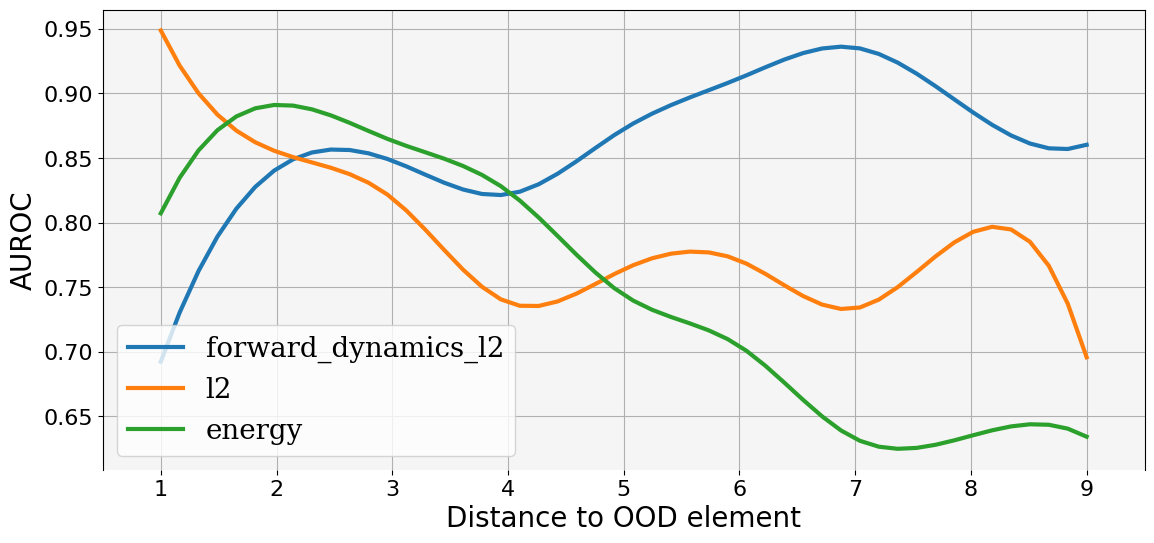

In [8]:
environment_selected = 'Lava'

distances = np.arange(1, 10)

# Figure settings
figsize = (12, 6)
fontsize = 20
fig,ax = plt.subplots(1,1,figsize=figsize)

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# jdelser used plot settings
plt.subplots_adjust(top=0.881,
                    bottom=0.114,
                    left=0.096,
                    right=0.964,
                    hspace=0.2,
                    wspace=0.146
                    )

ax.set_facecolor('whitesmoke')
ax.grid(True)
ax.xaxis.offsetText.set_fontsize(fontsize)
ax.spines['bottom'].set_visible(False)

# Plot the AUROC values
for method_name, values in auroc_per_env_per_method_per_distance[environment_selected].items():
    
    if method_name in ['forward_dynamics_l2', 'l2', 'energy']:

        mean_auroc_values, std_auroc_values = values[:, 0], values[:, 1]
        # plt.plot(distance, auroc_values, label=f'{method_name}', lw=3)
        # x_new, bspline, y_new
        x_new = np.linspace(1, 9, 50)
        bspline = interpolate.make_interp_spline(distances, mean_auroc_values)
        y_new = bspline(x_new)
        ax.plot(x_new, y_new, label=f'{method_name}', lw=3)
        
        # # Normalized auroc
        #total_auroc_value = total_auroc_per_method[method_name]
        # plt.plot(distance, auroc_values/total_auroc_value, label=f'{method_name}', lw=3)

        # FPR at a certain TPR
        #plt.plot(distance, fpr_at_certain_tpr, label=f'{method_name}', lw=3)

# Plot a dotter line in the AUROC value 1
#plt.plot([0, 9], [1, 1], 'k--', alpha=0.5, label='Normalized AUROC = 1')
plt.xticks(fontsize=fontsize-4)
plt.yticks(fontsize=fontsize-4)
# Make X axis start at 1
plt.xlim(0.5, 9.5)
#plt.ylim(0.6, 1)
plt.xlabel('Distance to OOD element', fontsize=fontsize)
plt.ylabel('AUROC', fontsize=fontsize)
#plt.title(f'Dist to OOD vs Normalized AUROC - {environment_selected}', fontsize=fontsize+2, pad=10)
plt.legend(fontsize=fontsize, loc='lower left')
plt.savefig(f'ood_storage/figs/rq1/auroc_vs_dist_to_ood_{environment_selected}.pdf')
plt.show()

#### Mean of all envs

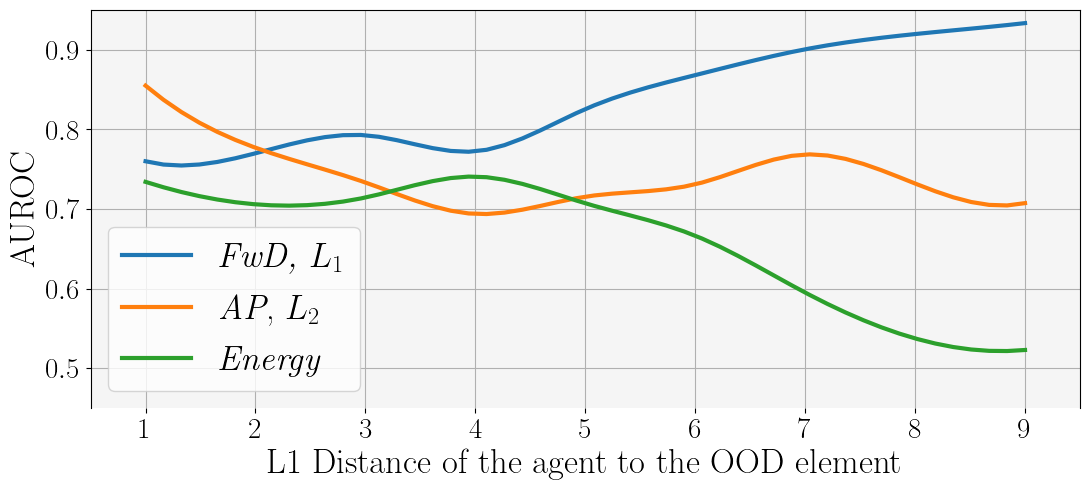

In [7]:
load_from_pickle = False
if load_from_pickle:
    import pickle
    # Load auroc_per_env_per_method_per_distance from a pickle file
    with open(f'ood_storage/auroc_per_env_per_method_per_distance.pkl', 'rb') as f:
        auroc_per_env_per_method_per_distance = pickle.load(f)

environment_selected = 'Sand050'

distances = np.arange(1, 10)

# Figure settings
figsize = (11, 5)
fontsize = 25
fig,ax = plt.subplots(1,1,figsize=figsize)

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

# jdelser used plot settings
plt.subplots_adjust(top=0.881,
                    bottom=0.114,
                    left=0.096,
                    right=0.964,
                    hspace=0.2,
                    wspace=0.146
                    )

ax.set_facecolor('whitesmoke')
ax.grid(True)
ax.xaxis.offsetText.set_fontsize(fontsize)
ax.spines['bottom'].set_visible(False)

envs_selected = [
    'Lava010',
    'Ball100',
    'Sand050',
]

mean_auroc_all_envs_per_method_per_distance = OrderedDict()
for method_name in auroc_per_env_per_method_per_distance['Lava010'].keys():
    auroc_one_method_all_envs = []
    for env in envs_selected:
        auroc_one_method_all_envs.append(auroc_per_env_per_method_per_distance[env][method_name][:, 0])
    mean_auroc_all_envs_per_method_per_distance[method_name] = np.mean(np.array(auroc_one_method_all_envs), axis=0)    

# Plot the AUROC values
for method_name, mean_auroc_values in mean_auroc_all_envs_per_method_per_distance.items():
    
    if method_name in ['forward_dynamics_l1', 'l2', 'energy']:
        
        x_new = np.linspace(1, 9, 50)
        bspline = interpolate.make_interp_spline(distances, mean_auroc_values)
        y_new = bspline(x_new)
        # Change label for the legend using a dict
        new_labels = {
            'forward_dynamics_l1': r'\emph{{FwD}, $L_1$',
            'forward_dynamics_l2': r'\emph{FwD}, $L_2$',
            'l2': r'\emph{AP}, $L_2$',
            'energy': r'\emph{Energy}',
        }
        ax.plot(x_new, y_new, label=f'{new_labels[method_name]}', lw=3)

# Plot a dotter line in the AUROC value 1
#plt.plot([0, 9], [1, 1], 'k--', alpha=0.5, label='Normalized AUROC = 1')
plt.xticks(fontsize=fontsize-4)
plt.yticks(fontsize=fontsize-4)
# Make X axis start at 1
plt.xlim(0.5, 9.5)
plt.ylim(0.45, 0.95)
plt.xlabel('L1 Distance of the agent to the OOD element', fontsize=fontsize)
plt.ylabel('AUROC', fontsize=fontsize)
#plt.title(f'Dist to OOD vs Normalized AUROC - {environment_selected}', fontsize=fontsize+2, pad=10)
plt.legend(fontsize=fontsize, loc='lower left')
plt.tight_layout()
plt.savefig(f'ood_storage/figs/rq1/auroc_vs_dist_to_ood_mean_of_envs.pdf')
plt.show()

# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "sans-serif"
# })

In [22]:
mean_auroc_all_envs_per_method_per_distance

OrderedDict([('forward_dynamics_l1',
              array([0.76003695, 0.77006725, 0.7927356 , 0.77244813, 0.82554894,
                     0.86821781, 0.90062437, 0.91978264, 0.93353975])),
             ('forward_dynamics_l2',
              array([0.71726302, 0.76572256, 0.79345692, 0.78327103, 0.83187254,
                     0.8692355 , 0.90312515, 0.91197242, 0.93616121])),
             ('l1',
              array([0.84789179, 0.76955823, 0.72823302, 0.68700097, 0.71435692,
                     0.73896395, 0.77570206, 0.73442526, 0.71863221])),
             ('l2',
              array([0.85503117, 0.77705358, 0.73335957, 0.69388034, 0.71553386,
                     0.73107692, 0.76856379, 0.73209391, 0.70745645])),
             ('l1_per_action',
              array([0.8024049 , 0.70610819, 0.6853624 , 0.67624397, 0.71405859,
                     0.74604563, 0.79785076, 0.76655029, 0.75650712])),
             ('l2_per_action',
              array([0.81791143, 0.72159167, 0.69625628, 0.

#### 3 envs

### Table of Performance in every env

In [20]:
df = pd.read_csv('ood_storage/performance_evaluation_P_MN5S8_1000_lvls_r_ep_im005_ent00005.csv')
df

,env,seed,num_episodes_played,num_episodes_solved,success_rate,sum_of_returns,mean_return,mean_return_in_solved_eps
0,MiniGrid-MultiRoom-N5-S8-v0,1,1000,964,0.964,634.582,0.634582,0.658280
1,MiniGrid-MultiRoomLava010-N5-S8-v0,1,1000,12,0.012,8.049,0.008049,0.670750
2,MiniGrid-MultiRoom-N5-S8-v0,2,1000,994,0.994,665.509,0.665509,0.669526
3,MiniGrid-MultiRoomLava010-N5-S8-v0,2,1000,14,0.014,9.005,0.009005,0.643214
4,MiniGrid-MultiRoom-N5-S8-v0,1,1000,964,0.964,634.582,0.634582,0.658280
...,...,...,...,...,...,...,...,...
285,MiniGrid-MultiRoomQuicksand050-N5-S8-v0,4,1000,599,0.599,350.285,0.350285,0.584783
286,MiniGrid-MultiRoom-N5-S8-v0,5,1000,996,0.996,670.281,0.670281,0.672973
287,MiniGrid-MultiRoomQuicksand050-N5-S8-v0,5,1000,485,0.485,291.923,0.291923,0.601903
288,MiniGrid-MultiRoom-N5-S8-v0,4,1000,984,0.984,659.847,0.659847,0.670576


In [21]:
env_mapping = {
    'normal_vs_lava':                           'Lava',
    'normal_vs_ball':                           'Ball',
    'normal_vs_sand':                           'Sand',
    'MiniGrid-MultiRoom-N5-S8-v0':              'MultiRoomN5S8',
    'MiniGrid-MultiRoomLava010-N5-S8-v0':       'Lava',
    'MiniGrid-MultiRoomBall100-N5-S8-v0':       'Ball',
    'MiniGrid-MultiRoomQuicksand050-N5-S8-v0':  'Sand',
    'MiniGrid-MultiRoom-N5-S20-v0':             'MultiRoomN5S20',
}

env_mean_return = {
    'MiniGrid-MultiRoom-N5-S8-v0':              [],
    'MiniGrid-MultiRoomLava010-N5-S8-v0':      [],
    'MiniGrid-MultiRoomBall100-N5-S8-v0':      [],
    'MiniGrid-MultiRoomQuicksand050-N5-S8-v0':  [],
    'MiniGrid-MultiRoom-N5-S20-v0':              [],

}
env_mean_return_in_solved_eps = deepcopy(env_mean_return)
env_success_rate = deepcopy(env_mean_return)

# Fill the lists with the repeated settings
for i, row in df.iterrows():
    key = row['env']
    if key not in env_mean_return.keys():
        continue
    env_mean_return[key].append(row['mean_return'])
    env_mean_return_in_solved_eps[key].append(row['mean_return_in_solved_eps'])
    env_success_rate[key].append(row['success_rate'])

# Compute the mean of all the lists
env_mean_return = {k: np.mean(v) for k, v in env_mean_return.items()}
env_mean_return_in_solved_eps = {k: np.mean(v) for k, v in env_mean_return_in_solved_eps.items()}
env_success_rate = {k: np.mean(v) for k, v in env_success_rate.items()}

# Create the table
df_table = pd.DataFrame.from_dict(env_mean_return, orient='index', columns=['mean_return'])
df_table['mean_return_in_solved_eps'] = env_mean_return_in_solved_eps.values()
df_table['success_rate'] = np.array(list(env_success_rate.values())) * 100
# Substite the env names with the mapping
df_table.index = df_table.index.map(env_mapping)
df_table

,mean_return,mean_return_in_solved_eps,success_rate
MultiRoomN5S8,0.657558,0.667827,98.452381
Lava,0.011107,0.669054,1.663415
Ball,0.010101,0.697303,1.460000
Sand,0.316534,0.594049,53.315000
MultiRoomN5S20,0.361556,0.509234,71.000000


#### Only performance table

In [26]:
# Change the column names using the following dict and drop the columns not included in the dict and follow the order of the dict
new_column_names = {
    'mean_return': 'Mean Return',
    'success_rate': 'Success Rate [\%]',
    # 'energy': 'Energy',
    # 'msp': 'MSP',
    # 'forward_dynamics_l1': 'FD-L1',
    # 'forward_dynamics_l2': 'FD-L2',
    # 'l1': 'L1',
    # 'l2': 'L2',
    # 'l1_per_action': 'L1-A',
    # 'l2_per_action': 'L2-A',
}
# Rename the columns
df_table = df_table.rename(columns=new_column_names)
# Drop columns that are not present in the dictionary
columns_to_drop = [col for col in df_table.columns if col not in list(new_column_names.values())]
df_table = df_table.drop(columns=columns_to_drop)
# Multiply all values by 100 (except for the 'mean_return' column)
#df_table.iloc[:, 1] *= 100
df_table = df_table.map(lambda x: '-' if x == 0 else f"{x:.2f}")

# Reorder the rows as in the following list
new_index_order = [
    'MultiRoomN5S8',
    'MultiRoomN5S20',
    'Lava',
    'Ball',
    'Sand',
]
# Reorder the rows
df_table = df_table.reindex(index=new_index_order)

# New index names
new_index_names = [
    r'\texttt{MN5S8}',
    r'\texttt{MN5S20}',
    r'\texttt{MN5S8-Lava}',
    r'\texttt{MN5S8-Ball}',
    r'\texttt{MN5S8-Sand}',
]
df_table.index = new_index_names

# Add a column indicating the if the environment is a OOD or Not
df_table['OOD env'] = ['No', 'No', 'Yes', 'Yes', 'Yes']
#df_table['OOD env'] = ['No', 'No', 'Yes','Yes','Yes', 'Yes']

df_table.to_latex('ood_storage/performance_table.tex')
df_table

,Mean Return,Success Rate [\%],OOD env
\texttt{MN5S8},0.65,98.24,No
\texttt{MN5S20},0.36,71.00,No
\texttt{MN5S8-Lava},0.01,1.78,Yes
\texttt{MN5S8-Ball},0.01,1.22,Yes
\texttt{MN5S8-Sand},0.31,52.93,Yes


#### Performance + AUROC

In [189]:
# PER STEP and for all environments
# Define folder path
detection_results_folder = Path("ood_storage/detection_results")

ood_settings_to_benchmark = [
    'normal_vs_lava',
    'normal_vs_ball',
    'normal_vs_sand',
]

per_step_or_per_level_evaluation = 'per_steps'

model_name = 'P_MN5S8_1000_lvls_r_ep_im005_ent00005_1'  # Para lava

ood_detection_distance = 9

seed = 1

results_per_setting_per_method = OrderedDict()
for ood_setting_to_benchmark in ood_settings_to_benchmark:
    # Only consider the .pt files in the folder
    results_per_method = OrderedDict()
    results_per_method_per_distance = OrderedDict()
    for file in sorted(detection_results_folder.iterdir()):
        if file.suffix != ".pt":
            continue

        # For each file (method), we will automatically extract the name of the method and the name of the environment from the file name
        file_name = file.name
        # TODO: Hack because ball and sand have different names
        pos_start_model_name = file_name.find(model_name)
        if pos_start_model_name == -1:  # If the model name is not in the file name, we skip the file
            continue
        methods_name = file_name[32:pos_start_model_name-1]
        per_step_or_per_level_current_file = file_name[22:31]
        ood_setting_name = file_name[file_name.find("ood_performance_evaluation") + len("ood_performance_evaluation") + 1 : -9]
        ood_detection_distance_current_file = file_name[-8:-6]
        if ood_detection_distance_current_file.isdigit():
            ood_detection_distance_current_file = int(ood_detection_distance_current_file)
        seed_current_file = file_name[-5:-3]
        if seed_current_file.isdigit():
            seed_current_file = int(file_name[-5:-3])
        else:
            seed_current_file = -1

        if ood_setting_name != ood_setting_to_benchmark:
            continue
        if per_step_or_per_level_current_file != per_step_or_per_level_evaluation:
            continue
        if methods_name == 'performance':
            continue
        if ood_detection_distance_current_file != ood_detection_distance:
            continue
        if seed_current_file != seed:
            continue
        
        #print(methods_name, '-', ood_setting_name)
        
        # Load the results
        results = torch.load(file)

        # Results for all distances
        # Compute the TPR, FPR and precision to plot auroc
        tpr_fpr_precision = extract_tpr_fpr_precision_from_results_file(results=results, per_step_results=True)

        # Store the results
        results_per_method[methods_name] = tpr_fpr_precision

    # Auroc per method
    auroc_values_per_method = compute_auroc_per_method(results_per_method=results_per_method, per_step_results=True)
    
    # Store the results
    results_per_setting_per_method[ood_setting_to_benchmark] = auroc_values_per_method

# Transform the hierarchy to a dict per method and per environment
results_per_method_per_setting = OrderedDict()
for method_name, auroc_value in auroc_values_per_method.items():
    results_per_method_per_setting[method_name] = OrderedDict()
    # Add the MultiRoomN5S20 with all 0s for the auroc values
    results_per_method_per_setting[method_name]['MultiRoomN5S8'] = 0
    for setting_name, auroc_values_per_method in results_per_setting_per_method.items():
        results_per_method_per_setting[method_name][env_mapping[setting_name]] = results_per_setting_per_method[setting_name][method_name]
    # Add the remaining environment (MultiRoomN5S20) with all 0s for the auroc values
    results_per_method_per_setting[method_name]['MultiRoomN5S20'] = 0
#results_per_method_per_setting

In [190]:
# Add the columns (methods) to the existing df_table. The index is the environment.
for method_name, results_per_setting in results_per_method_per_setting.items():
    df_table[method_name] = results_per_setting.values()

# Multiply all values by 100 (except for the 'mean_return' column)
df_table.iloc[:, 3:] *= 100
df_table = df_table.map(lambda x: '-' if x == 0 else f"{x:.2f}")
df_table

In [179]:
#df_table.map(lambda x: '-' if ((x == 0) and (x != df_table['mean_return'])) else f"{x:.2f}")
#df_table.map(lambda x: f"{x:.2f}")
#df_table.map(lambda x: '-' if x == 0 else f"{x:.2f}")

In [192]:
# Change the column names using the following dict and drop the columns not included in the dict and follow the order of the dict
new_column_names = {
    'mean_return': 'Mean Return',
    'success_rate': 'Success Rate',
    'energy': 'Energy',
    'msp': 'MSP',
    'forward_dynamics_l1': 'FD-L1',
    'forward_dynamics_l2': 'FD-L2',
    'l1': 'L1',
    'l2': 'L2',
    'l1_per_action': 'L1-A',
    'l2_per_action': 'L2-A',
}
# Rename the columns
df_table = df_table.rename(columns=new_column_names)
# Drop columns that are not present in the dictionary
columns_to_drop = [col for col in df_table.columns if col not in list(new_column_names.values())]
df_table = df_table.drop(columns=columns_to_drop)
df_table

,Mean Return,Success Rate,Energy,FD-L1,FD-L2,L1,L1-A,L2,L2-A,MSP
MultiRoomN5S8,0.63,96.42,-,-,-,-,-,-,-,-
Lava,0.07,10.53,76.89,84.92,84.32,84.27,78.61,84.83,81.40,76.89
Ball,0.01,1.07,61.47,71.95,70.11,61.84,57.21,63.29,58.89,61.47
Sand,0.37,63.52,80.85,79.23,75.37,85.66,80.52,86.26,82.21,80.85
MultiRoomN5S20,0.36,71.00,-,-,-,-,-,-,-,-


In [193]:
# Reorder the rows as in the following list
new_index_order = [
    'MultiRoomN5S8',
    'MultiRoomN5S20',
    'Ball',
    'Lava',
    'Sand',
]

# Reorder the rows
df_table = df_table.reindex(index=new_index_order)
df_table


,Mean Return,Success Rate,Energy,FD-L1,FD-L2,L1,L1-A,L2,L2-A,MSP
MultiRoomN5S8,0.63,96.42,-,-,-,-,-,-,-,-
MultiRoomN5S20,0.36,71.00,-,-,-,-,-,-,-,-
Ball,0.01,1.07,61.47,71.95,70.11,61.84,57.21,63.29,58.89,61.47
Lava,0.07,10.53,76.89,84.92,84.32,84.27,78.61,84.83,81.40,76.89
Sand,0.37,63.52,80.85,79.23,75.37,85.66,80.52,86.26,82.21,80.85


In [194]:
df_table.to_latex('ood_storage/auroc_per_method_per_env.tex')

In [ ]:
def compute_auroc_and_fpr_for_all_seeds(results_per_seed: List, which_tpr_for_the_fpr=0.95) -> dict:
    fpr_at_certain_tpr = []
    auroc_fpr_all_seeds = []
    for i, values in enumerate(results_per_seed):
        
        TPR, FPR, PRECISION = values[:, 0], values[:, 1], values[:, 2]

        # Compute the TPR at a certain FPR
        index_closest = np.argmin(np.abs(TPR - which_tpr_for_the_fpr))
        fpr_at_certain_tpr.append(FPR[index_closest])
        auroc_fpr_all_seeds.append([np.abs(np.trapz(TPR, FPR)), FPR[index_closest]])

    # Convert the lists into numpy arrays
    auroc_fpr_all_seeds = np.array(auroc_fpr_all_seeds)
    # Now compute the mean and std
    auroc_mean = np.mean(auroc_fpr_all_seeds[:, 0])
    auroc_std = np.std(auroc_fpr_all_seeds[:, 0])
    fpr_mean = np.mean(auroc_fpr_all_seeds[:, 1])
    fpr_std = np.std(auroc_fpr_all_seeds[:, 1])
    
    # Create an array with the mean and std of the auroc and fpr
    auroc_fpr_mean_std = np.array([[auroc_mean, auroc_std], [fpr_mean, fpr_std]])
    return auroc_fpr_mean_std

#def compute_auroc_and_fpr_vs_distance_for_all_seeds()
    
def avg_and_std_per_distance(auroc_per_seed_per_distance: List) -> List:
    auroc_per_distance = []

    #print(auroc_per_seed_per_distance)
    # print(len(auroc_per_seed_per_distance))
    # print(len(auroc_per_seed_per_distance[0]))
    # Accumulate the auroc of each seed for each distance
    auroc_per_distance_all_seeds = OrderedDict()
    for i in range(1, len(auroc_per_seed_per_distance[0])+1):
        auroc_per_distance_all_seeds[i] = []

    for i, values_one_seed in enumerate(auroc_per_seed_per_distance):
        for distance, auroc_val, fpr_at_certain_tpr in values_one_seed:
            auroc_per_distance_all_seeds[int(distance)].append(auroc_val)
    
    # Now compute the mean and std
    for d, auroc_one_dist_all_seeds in auroc_per_distance_all_seeds.items():
        #print(d, auroc_one_dist_all_seeds)
        auroc_per_distance.append([np.mean(auroc_one_dist_all_seeds), np.std(auroc_one_dist_all_seeds)])
    
    return auroc_per_distance